## Homework 1
### Hasan Cetin
---

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d


import quantecon as qe
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

plt.style.use('seaborn-notebook')

In [3]:
#Input the parameter values

α = 0.7
β = 0.98
ρ = 0.9
e = np.exp(1)
tol = 10e-5

# 1) VFI

# Deterministic Case

Let's first try to solve the deterministic case where $z_t = 10$:

# 1.1) Deterministic Case

Let's first try to solve the deterministic case where $z_t = 10$:

In [10]:
class VFI_growth_model_deterministic:
    
    def __init__(self, k_min=0.05, k_max=10, grid_size=100, α=0.6, β=0.6, δ = 0.5, z=10, ϵ=10e-6):
        self.k_min, self.k_max, self.grid_size, self.α, self.β, self.δ, self.z, self.ϵ = k_min, k_max, grid_size, α, β, δ, z, int(ϵ)
    
    def create_grid(self):
        """Creates grid of X, vector of Γ, V, TV with dimension of grid_size"""
        X = np.linspace(self.k_min, self.k_max, self.grid_size)
        Γ = np.ones(self.grid_size)*(-1)
        V = np.zeros(self.grid_size)
        TV = np.ones(self.grid_size)
        return X, Γ, V, TV
    
    def returnFun(self, x_index, a_index, X, V):
        """Computes the Value given x, a, X, V"""
        x = X[x_index]
        a = X[a_index]
        
        if x ** self.α + (1-self.δ)*x - a < 0: #Negative Consumption Case
            return -1000
        else:
            return np.log(x ** self.α + (1-self.δ)*x - a) + self.β * V[a_index]
        
    def computeMax(self, x_index, X, V):
        """Computes max value and optimal policy given x, X, V"""
        solution = -100000
        optimal_index = -1
        for i in range(self.grid_size):
            value = self.returnFun(x_index, i, X, V)
            
            if value > solution:
                solution = value
                optimal_index = i
        return solution, optimal_index
    
    def ValueFun(self, X, V):
        """Gets TV after doing computeMax function for all x, given X, V"""
        Γ = np.ones(self.grid_size)*(-1)
        TV = np.ones(self.grid_size)
        
        for i in range(self.grid_size):
            TV[i], Γ[i] = self.computeMax(i, X, V)
        
        return TV, Γ
            
    def mainFunction(self):
        """Iteration until convergence"""
        X, Γ, V, TV = self.create_grid()
        g = np.empty(self.grid_size)
        dist = 1000
        ϵ = self.ϵ
        
        while dist > ϵ:
            TV, Γ = self.ValueFun(X, V)
            dist = max(np.abs(TV - V))
            V = np.copy(TV)
            
        Γ = Γ.astype(int)                #Getting optimal value
        for i in range(self.grid_size):
            g[i] = X[Γ[i]]
            
        return X, TV, Γ, g
    
    def __call__(self):
        return self.mainFunction()
    

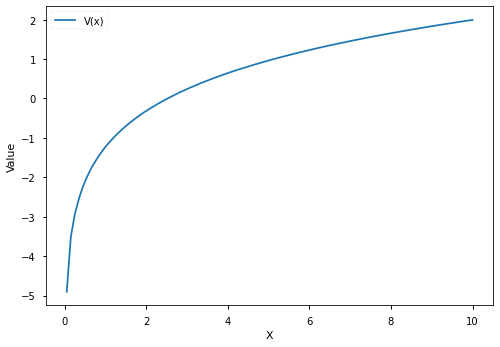

In [11]:
X ,TV, Γ, g = VFI_growth_model_deterministic()()

fig, ax = plt.subplots()

ax.plot(X, TV, label='V(x)')
ax.set_xlabel('X'); ax.set_ylabel('Value'); ax.set_label('Value function')
ax.legend()
plt.show()

#  1.2) Stochastic Case

Now $z_t$ is stochastic. What is our new Bellmann Operator:

$$ (TV)(y) = \max_{0 \leq c \leq y} u(c) + \beta \int V(f(y-c)z))\phi(dz)$$

where:

$$f(y_t-c_t) = z_t(y_t-c_t)^\alpha$$
$$[log(z_{t+1}) = \rho_0 + \rho log(z_t) + \epsilon_{t+1}] \equiv [z_{t+1} = z_t^\rho + exp(\rho_{0} + \epsilon_{t+1})], \;\;\;\; \epsilon \sim N(0, \sigma^2_{\epsilon})$$

Here, $\psi_{t+1} = exp(\rho_{0} + \epsilon_{t+1})$ can be considered as the shock.

Note that $z_{t+1} = z_t^\rho + exp(\rho_{0} + \epsilon_{t+1})$ is an AR(1) process. Two possibilities:

- $\rho = 0$: Then it is simple to solve since defining a shock vector is enough to solve the problem. Because the process does not depend on previous factor z_t.
- $\rho \not = 0$: It is more problematic since it is AR(1) process and we need to define Markov tranisition matrix Q to solve the problem.

## 1.2.1) $\rho$ = 0 case:

Let's determine what the parameters of the problem are:

- $\beta$, Time discounting factor
- $\rho_0$, $\rho$, Factor production parameters                
- $\mu = 0$, $\sigma^2_\epsilon$,   Distribution parameters of the shock
- utility function $u$, production function $f$
- grid size of values $grid\_size$
- grid size of shocks $shock\_size$

Now, before defining our class, note that we are going to use Monte Carlo simulation to compute the integral.

$$\int V(f(y-c)z) \phi(dz) \approx \dfrac{1}{n} \sum_{i = 1}^{n}V(f(y-c)z)\psi_i$$

where $\psi_i \equiv exp(\rho_0 + \epsilon_{i})$ are IID draws.

Note also that we have finite grid points but $f(y-c)z$ might not be one of those grid points? What should we do?

Answer: Use interpolation! We'll use linear interpolation for simplicity. We'll use `scipy.interpolate.interp1d` method.
    
`.RHS_Bellman` in our class will compute RHS of the bellman equation. We need to maximize it as well. To do this, we are going to use `scipy.optimize.minimize_scalar`. To make our class definition shorter and to be able to use it in general case, we'll define maximize function outside of the class definition

In [15]:
def maximize(f, a, b, args):
    """maximize the function f on [a,b] by minimizing -f on [a,b]. args is used for arguments of the function f"""
    function = lambda x: -f(x, *args)
    result = minimize_scalar(function, bounds=(a,b), method='bounded')
    maximizer, maximum = result.x, result.fun
    
    return maximizer, maximum

In [16]:
class VFI_growth_model_stochastic:
    
    def __init__(self,u, f, β=0.96, ρ_0=0, ρ=0.8, σ=1 , μ=0, grid_size=100, shock_size=250, random_seed = 1234):
        self.β = β                      #time discounting factor
        self.ρ_0 = ρ_0                  #ρ_0
        self.ρ = ρ                      #ρ
        self.μ = μ                      #μ
        self.σ = σ                      #σ^2_{ϵ}
        self.u = u                      #utility function
        self.f = f                      #production function
        self.grid_size = grid_size      #grid size for the values
        self.shock_size = shock_size    #grid size for the shocks
        self.random_seed = random_seed   #for getting the same value everytime
        
        #setting up grid
        self.grid = np.linspace(1e-4, 4, self.grid_size)           #grid_size x 1 of equally spaced grid vector
        
        #setting up shocks
        np.random.seed = self.random_seed
        self.shocks =  self.ρ_0 + np.random.normal(loc= self.μ, scale = self.σ, size = self.shock_size) #shock_size x 1 vector of shocks
        
    def RHS_Bellman(self, c, y ,v_values):
        """RHS of the Bellman operator"""
        u, f, β, shocks = self.u, self.f, self.β, self.shocks #for simplicity
        
        v = interp1d(self.grid, v_values)  #self.grid = x, v_values=y and linearly interpolate inbetween
        
        RHS = u(c) + β * 1/len(shocks) * np.sum(v(f(y-c)) + np.exp(shocks + self.ρ_0))
        
        return RHS
        
    def T(self,v):
        """Bellmann operator T. Computes TV and put it back to V on RHS and iterates"""
        v_new = np.empty_like(v)
        opt_policy = np.empty_like(v) #Create value vectors to be filled as the same size of argument v.
        
        for i in range(self.grid_size):
            y = self.grid[i]
            c_star, v_max = maximize(self.RHS_Bellman, 1e-10, y, args= (y,v))
            v_new[i] = v_max
            opt_policy[i] = c_star
        return opt_policy, v_new

Now let's guess $V^*$:

In [17]:
def v_star(y, α, β, μ):
    """
    Theoretic value function
    """
    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)
    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

def σ_star(y, α, β):
    """
    Theoretic optimal policy
    """
    return (1 - α * β) * y

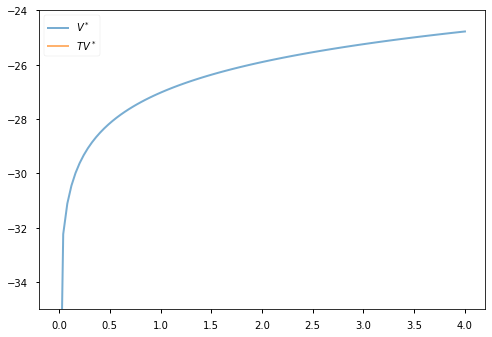

In [18]:
α = 0.4
def fcd(k):
    return k**α

og = VFI_growth_model_stochastic(u= np.log, f= fcd)

grid = og.grid

v_theoretical = v_star(grid, α, og.β, og.μ)    # Start from our theoric value function values
Tv_theoretical, v = og.T(v_theoretical)             # Apply T once

fig, ax = plt.subplots()
ax.set_ylim(-35, -24)
ax.plot(grid, v_theoretical, lw=2, alpha=0.6, label='$V^*$')
ax.plot(grid, Tv_theoretical, lw=2, alpha=0.6, label='$TV^*$')
ax.legend()
plt.show()

As we can see, $TV^* = V^*$ so indeed our theoretic value function is the unique fixed point of the Bellmann equation.



## 1.2.2) $\rho \not = 0$ case:

If we look at our AR(1) process, it is:

$$z_{t+1} = z^{\rho}_t + exp(\epsilon_{t+1})$$

But as you can see, it is a non-linear AR(1) process. What should we do?

Answer: Instead of tracking z's, track $\hat{z} = log(z)$'s! Then, when we want to use $\hat{z}$ in our production function, just take exponential of $\hat{z}$. So, we have: 

$$\hat{z}_{t+1} = \rho \hat{z}_t + \epsilon_{t+1} \;\;\;\; \epsilon \sim N(0,\sigma^2_{\epsilon})$$

Now, we need to find a **stationary Markov transition matrix $Q((z,k), z')$** which takes current period productivity and capital as input, and gives probability distribution of next period's productivity

Now, let N be the grid size of z and M be the grid size of shocks. Then Q would be MxNxN matrix. But for simplicity, take M = N to have NxNxN transition matrix Q. 

Another thing is that, when we make grid of shocks and productivity z's, then next period z' will lie in the same grid that we used for z's. Which means we can use 2d NxN matrix for transition matrix. We are going to use `qe.markov` to construct this Stationary Markov Process.

$Q((z,s),z')$: Probability of next period's factor is z', given z,s today.

We'll use `qe.markov.approximation.rouwenhorst` method to **discretize Gaussian linear AR(1) processes** in form $y_t = \bar{y} + \rho y_{t-1} + \varepsilon_t$ via Rouwenhorst's method. 



Note that now, the value function will be a NxN matrix as well. 

Again, let's list the inputs (parameters) of the problem:

- grid_size: To make Matrix of shocks and productivity
- $z_0$: initial productivity
- $\sigma$: standard deviation of shocks
- $\theta$: production parameter
- $\rho$: AR(1) parameter
- $\beta$: Time discounting

In [1]:
class VFI_stochastic_2:
    def __init__(self, p=0.9, capital_grid=100, shock_grid=25, z_0=0, var=0.01, θ=0.7, 
                 β=0.98, ϵ=10e-5, max_iter = 1000):
        self.p = p                                                       #\rho in AR(1) process in technology
        self.β = β                                                       #discount factor
        self.θ = θ                                                       #capital share
        self.shock_grid = shock_grid                                     #Grid size for shocks
        self.capital_grid = capital_grid                                 #Capital stock grid size
        self.z_0 = z_0                                                   #Initial technology parameter
        self.ϵ = ϵ                                                       #Tolerance level for convergence
        self.max_iter = max_iter                                         #Maximum iteration
        self.iterations = 0                                              #Iteration number of the VFI process

        self.V = np.zeros((shock_grid, capital_grid))                    #Initial V(Z,K)
        self.TV = np.ones((shock_grid, capital_grid))                    #Initial TV(Z,K)

        self.Markov = qe.markov.approximation.rouwenhorst(shock_grid, z_0, var, p) #Discretized Gaus linear AR(1)
        self.Π = self.Markov.P                                           #Transition Matrix of the process
        self.Z = np.exp(self.Markov.state_values)                        #Transform \hat{z} = log(z) to real z

        self.K_max = max(self.Z)**(1/(1-θ))                              #Max capital stock
        self.K = np.linspace(0.001, self.K_max, capital_grid)            #Capital stock grid

    def Utility(self, x):
        return np.log(x)

    def update(self):
        shock_grid, capital_grid, K, Π, θ, β, Z = self.shock_grid, self.capital_grid, self.K, self.Π, self.θ, self.β, self.Z
        self.V = np.copy(self.TV)
        for s in range(shock_grid):
            for k in range(capital_grid):
                self.TV[s,k] = np.nanmax(self.Utility(Z[s] * K[k]**θ - K) + β * np.matmul(Π[s, :], self.V))
        
    
    def error(self):
        TV, V = self.TV, self.V
        return np.nanmax(np.abs(TV-V))

    def VFI(self):
        while self.iterations < self.max_iter and self.error() > self.ϵ:
            self.update()
            self.iterations += 1
        
        if self.iterations < self.max_iter:
            print('Solution has been found!!!!!')
        else:
            print('Not today :(')

    def plot(self, z):
        fig, ax = plt.subplots()
        ax.plot(self.K[(self.K > 0.1)], self.TV[z,(self.K > 0.1)], 'r-', linewidth=2, label='Value function', alpha=0.6)
        plt.title('z=' + str(self.Z[z]))
        plt.xlabel('K')
        plt.ylabel('V(z,k)')
        plt.show()
        

    def __call__(self):
        self.VFI()
        return self.TV, self.error(), self.iterations, self.Z, self.K

In [4]:
VFI_model = VFI_stochastic_2()

VFI_model.VFI()

print("The error is: " + str(VFI_model.error()))

Solution has been found!!!!!
The error is: 9.89188840208044e-05


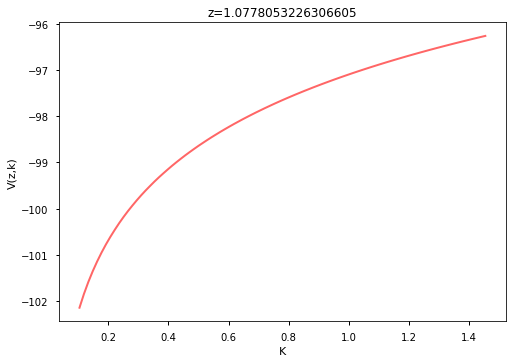

In [5]:
VFI_model.plot(20)

# 2.1) LQ Model

Note: To be able to solve the LQ model, I used Marimon and Scott's "Computational Methods for the Study of Dynamic Economies" book.

LQ approximation is reasonable when the following conditions are met:

- The deterministic version of the model converges to stable steady state.
- Linear Law of motion of the state variables.

A typical LQ problem can be written as: 

$$V(z,s) = \max_{d}\{r(z,s,d) + \beta \; \mathbb{E}[V(z',s')|z]\}$$

$$s.t. \;\;\; s' = A(z,s,d), \;\; z' = L(z) + \epsilon', \;\; \epsilon \sim N(0,\sigma)$$

where:

- z: $n_z$x$1$ vector of **exogenous state variables**

- s: $n_s$x$1$ vector of **endogenous state variables**

- d: $n_d$x$1$ vector of **control variables**

- $\epsilon$: $n_{\epsilon}x1$ vector of **shocks** with zero mean and finite variance

- r: return function

- A,L: Linear law of motions of state variables

A general solution algorithm for LQ problems is:

1. Choose a point about which to expand the return function. In most cases, it is the steady state point of the deterministic version of the model: $(\bar{z},\bar{s}, \bar{d})$, that we obtain when we substitute the random variables with their unconditional means.

2. Construct a quadratic approximation of $r(z,s,d)$ about $(\bar{z},\bar{s}, \bar{d})$.

3. Compute optimal value function $V^*(z,s)$ by succesive iterations on Bellman operator:

    $$V_{n+1}(z,s) = T[V_n(z,s)] = \max_{d}\{r(z,s,d) + \beta \; \mathbb{E}[V_n(z',s')|z]\}$$


### Step 1: Computing $(\bar{z},\bar{s}, \bar{d})$

In our problem:

- z: z (technology)
- s: k (current capital stock)
- d: x (investment) [or k' since there is full depreciation]
- r(z,k,x): $log(e^{z}k^{\alpha} - x)$
- A(z,k,x): x
- L(z): $\rho z $ so that the law of motion of technology: $\rho z + \epsilon' = z'$


First, we are going to take log of z, k, x and denote them with hats:

$$\hat{z} = log(z),\;\; \hat{k} = log(k), \;\; \hat{x} = log(x)$$

The reason we are doing this is to make law of motion being linear.

To compute the deterministic steady state, we substitute shocks by their unconditional mean: $\epsilon_{t+1} = 0$. So, since $\rho < 1$, in limit, $\lim_{t -> \infty} \hat{z}_t = 0$. So in steady state it should be:
 $$\large\bar{\hat{z}} = 0 \rightarrow \bar{z} = 1$$

Now lets write the deterministic version of the problem to find its steady state:

$$\max_{c_t, k_{t+1}}\sum \beta^t log(c_t)$$
$$s.t. \;\;\; c_t + x_t = k_t^\alpha, \;\;\; k_{t+1} = x_t\;\; c_t,k_{t+1}\geq 0,\;\; k_0 \;given$$

From its FOC's we have:

$$\frac{c_{t+1}}{c_t} = \beta[\alpha k_{t+1}^{\alpha-1}]$$

In steady state,$\frac{c_{t+1}}{c_t}= 1$. So we have:

$$\bar{k} = [\alpha \beta]^{\frac{1}{1-\alpha}}$$

$$\bar{x} = \bar{k}$$

So, our steady state that we are going to expand the return function is: 
$$\large(\bar{\hat{z}},\bar{\hat{k}}, \bar{\hat{x}}) = (0,log([\alpha \beta]^{\frac{1}{1-\alpha}}),log([\alpha \beta]^{\frac{1}{1-\alpha}}))$$

### Step 2: Constructing the quadratic approximation of the return function

We will use **2nd order Taylor approximation** to make r(z,s,d) our return function quadratic:

$$r(z,s,d) \simeq \bar{R} + (W-\bar{W})^T\bar{J} + \dfrac{1}{2}(W-\bar{W})^T\bar{H}(W-\bar{W})$$

where:

- $W$: $[z,s,d]^T$, vector of ordered state and control variables

- $\bar{W}$: $[\bar{z},\bar{s},\bar{d}]$, steady state values

- $\bar{R}$: $r(\bar{z},\bar{s},\bar{d})$ (i.e. return value evaluated at the steady state)

- $\bar{J}$: $[\bar{J}_z, \bar{J}_s, \bar{J}_d]^T$(i.e. **Jacobian** evaluated at the steady state) 

- $\bar{H}$: **Hessian** evaluated at the steady state:

$$\bar{H} = \begin{bmatrix} \bar{H}_{\bar{z}\bar{z}} & \bar{H}_{\bar{z}\bar{s}} & \bar{H}_{\bar{z}\bar{d}} \\ \bar{H}_{\bar{s}\bar{z}} & \bar{H}_{\bar{s}\bar{s}} & \bar{H}_{\bar{s}\bar{d}} \\ \bar{H}_{\bar{d}\bar{z}} & \bar{H}_{\bar{d}\bar{s}} & \bar{H}_{\bar{d}\bar{d}} \end{bmatrix}$$

The Taylor approximation can be written as:

$$r(z,s,d) \simeq (\bar{R} - \bar{W}^T\bar{J} + \dfrac{1}{2}\bar{W}^T\bar{H}\bar{W}) + W^T(\bar{J}-\bar{H}\bar{W}) + \dfrac{1}{2}W^T\bar{H}W$$

And this equation can be written in **quadratic form** as:

$$r(z,s,d) \simeq \begin{bmatrix}1 & W^T\end{bmatrix}\begin{bmatrix}Q_{11} & Q_{12}^T \\ Q_{12} & Q_{22}\end{bmatrix} \begin{bmatrix}1\\ W\end{bmatrix} \;\;\; \equiv \;\;\; \begin{bmatrix}1 & W^T\end{bmatrix}Q\begin{bmatrix}1 \\ W \end{bmatrix}$$ 

where:

- $Q_{11} = \bar{R} - \bar{W}^T\bar{J} + \dfrac{1}{2}\bar{W}^T\bar{H}\bar{W}$


- $Q_{12} = \dfrac{1}{2}(\bar{J} - \bar{H}\bar{W})$


- $Q_{22} = \dfrac{1}{2}\bar{H}$

Here, the role of 1 is to select the constant term of the quadratic expression.

Dimension of Q is $n_z + n_s + n_d + 1$

### Step 3: Computing the Optimal Value Function

Bellman operator is:

$$V_{n+1}(z,s) = \max_{d}\{[1\, W^T]\,Q\,[1\, W]^T + \beta\; \mathbb{E}[V_n(z',s')|z]\}$$
$$s.t. \;\;\; s' = A(z,s,d),\;\; z'=L(z) + \epsilon'$$

The initial guess should be a quadratic and concave function $ V_n = F^TP_nF$ where $\large F=[1,z,s]^T$, $P_n$ is summetric and negative semidefinite matrix with dimension $1+n_z + n_s$

Note that any square matrix with dimension $(1+n_z + n_s)$x$(1+n_z + n_s)$ with very small negative numbers on the diagonal and zeros anywhere else would satisfy $P_n$'s necessary conditions.


We will use **Certainity Equivalence Principle**, because in genereal operating with expectation is a hard thing to do. Note that certainity equivalence principle holds only when the objective function is quadratic and the constraints are linear.

By certainity equivalence, the covariance matrix of the vector of random variables $\Sigma = CC' = 0$ , so our Bellmann operator becomes:

$$V_{n+1} = \max_{d}\{[1\, W^T]\,Q\,[1\, W]^T + \beta\; (F')^TP_n(F')\}$$
$$s.t. \;\;\; s' = A(z,s,d),\;\; z' = L(z)$$

Next step is to transform this Bellmann operator as a quadratic function of $[1 W]^T$. To do this, we use constraints A, L to substitute the forwarded values of the states out of our Bellmann operator.

Specifically, we need to find a rectangular matrix B (a matrix of linear constraints) of dimension $(1 + n_z + n_s)$x$(1 + n_z + n_s + n_d)$ which satisfies:

$$F' = B[1 W]^T$$

(i.e. $B [1 \; W]^T$ is the law of motion of state variable $F = [1, z, s]^T$)

In our model, the B is:

$$B = \begin{bmatrix}1 & 0 & 0 & 0 \\ 0 & \rho & 0 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix}$$

After finding B, we substitute F' in Bellmann operator with $B[1 W]^T$ and we get

$$V_{n+1} = \max_{d}\{[1\, W^T]\,Q\,[1\, W]^T + \beta\; [1 W^T]B^TP_nB[1 W^T]^T\}$$

Notice that we get rid of the constraints by introducing B. (we incorporated them into the objective function)

As you can see the objective function is now a quadratic function of $[1 W]^T$:

$$V_{n+1} = \max_{d}\{[1\, W^T]\,(Q + \beta\; B^TP_nB)[1 W^T]^T\}$$

Next step is to differentiate this new Bellmann operator to obtatin decision rules $d_n(z,s)$.(i.e. solve the maximization problem on RHS)

Note that since the objective function is quadratic, the FOC's will be linear in $(z,s)$.

To make the calculations easier we are going to seperate state variable and control variable calculations by making partitions. First, define a partition of Q:

$$Q = \begin{bmatrix}\hat{Q}_{FF} & \hat{Q}_{Fd}^T \\ \hat{Q}_{Fd} & \hat{Q}_{dd}\end{bmatrix}$$

and define:

$$M_n = B^TP_nB \;\;\;\;\;\;\; M_n = \begin{bmatrix}M^n_{FF} & (M^n_{Fd})^T \\ M^n_{Fd} & M^n_{dd}\end{bmatrix}$$

Note that $Q_{FF}$... is not necessarily equal to $Q_{11}$... We define this new partition just to simplify the algebra. However, in our model, they are going to coincide.

Here:

- $Q_{FF}$ and $M^n_{FF}$: Symmetric matrices of dimension $(1+n_z + n_s)$x$(1+n_z + n_s)$
- $Q_{Fd}$ and $M^n_{Fd}$: Symmetric matrices of dimension $n_d$x$n_d$
- $Q_{FF}$ and $M^n_{FF}$: Rectangular matrices of dimension $n_d$x$(1+n_z + n_s)$

Substituting this partitions into our Bellmann operator, it becomes: (remember $[1 W]^T = [F d]^T$)

$$V_{n+1} = \max_{d} \begin{bmatrix} F^T & d^T\end{bmatrix} \begin{bmatrix} Q_{FF} + \beta M^n_{FF} & Q_{Fd}^T + \beta (M^n_{Fd})^T \\ Q_{Fd} + \beta M^n_{Fd} & Q_{dd} + \beta M^n_{dd}\end{bmatrix} \begin{bmatrix} F\\ d \end{bmatrix}$$

This can be rewritten as:

$$V_{n+1} = \max_{d} F^T [Q_{FF} + \beta M_{FF}^n]F + 2d^T[Q_{Fd} + \beta M_{Fd}^n]F + d^T[Q_{dd} + \beta M_{dd}^n]d$$


The RHS is a maximization problem with respect to d. So differentiate RHS with respect to $d^T$ (use matrix differentiation tactics):

$$2 [Q_{Fd} + \beta M_{Fd}^n] F + 2 [Q_{dd} + \beta M_{dd}^n]d = 0$$



Thus, the optimal policy function is:

$$\large d_n(z,s) = -(Q_{dd} + \beta M_{dd}^n)^{-1}(Q_{Fd} + \beta M_{Fd}^n)F \;\; \equiv \;\; G_n^TF$$

Define:

$$P_{n+1} = Q_{FF} + \beta M_{FF}^n - (Q_{Fd} + \beta M_{Fd}^n)^T(Q_{dd} + \beta M_{dd}^n)^{-1}(Q_{Fd} + \beta M_{Fd}^n)$$

Then:

$$V_{n+1} = F^TP_{n+1}F$$

We will do the vlaue function iteration until $P_n = P_{n+1}$


In [4]:
class Derivatives_at_SS:
    """This class is for generating Jacobian and Hessian matrix numerically at the steady state"""

    def __init__(self, f, z, s, d):
        self.f = f                 #Objective function
        self.z = z                 #Steady state value of z
        self.s = s                 #Steady state value of s
        self.d = d                 #Steady state value of d
    
    def Δz(self):
        f, z, s, d = self.f , self.z, self.s, self.d 
        Δ = max(10e-8,abs(z)*10e-4)
        return (f(z+Δ,s,d) - f(z,s,d))/ Δ

    def Δs(self):
        f, z, s, d = self.f , self.z, self.s, self.d 
        Δ = max(10e-8,abs(s)*10e-4)
        return (f(z,s+Δ,d) - f(z,s,d))/ Δ

    def Δd(self):
        f, z, s, d = self.f , self.z, self.s, self.d 
        Δ = max(10e-8,abs(d)*10e-4)
        return (f(z,s,d+Δ) - f(z,s,d))/ Δ

    def Δzz(self):
        f, z, s, d = self.f , self.z, self.s, self.d 
        Δ = max(10e-8,abs(z)*10e-4)
        μ = max(10e-8,abs(z)*10e-4)
        derivative = (((f(z + Δ + μ, s, d) - f(z+μ,s,d))/Δ) - ((f(z+Δ, s, d) - f(z,s,d))/Δ))/μ
        return derivative

    def Δzs(self):
        f, z, s, d = self.f , self.z, self.s, self.d 
        Δ = max(10e-8,abs(z)*10e-4)
        μ = max(10e-8,abs(s)*10e-4)
        derivative = (((f(z + Δ, s+μ, d) - f(z,s+μ,d))/Δ) - ((f(z+Δ, s, d) - f(z,s,d))/Δ))/μ
        return derivative

    def Δzd(self):
        f, z, s, d = self.f , self.z, self.s, self.d 
        Δ = max(10e-8,abs(z)*10e-4)
        μ = max(10e-8,abs(d)*10e-4)
        derivative = (((f(z + Δ, s, d+μ) - f(z,s,d+μ))/Δ) - ((f(z+Δ, s, d) - f(z,s,d))/Δ))/μ
        return derivative

    def Δsd(self):
        f, z, s, d = self.f , self.z, self.s, self.d 
        Δ = max(10e-8,abs(s)*10e-4)
        μ = max(10e-8,abs(d)*10e-4)
        derivative = (((f(z, s+Δ, d+μ) - f(z,s,d+μ))/Δ) - ((f(z, s+Δ, d) - f(z,s,d))/Δ))/μ
        return derivative

    def Δdd(self):
        f, z, s, d = self.f , self.z, self.s, self.d 
        Δ = max(10e-8,abs(d)*10e-4)
        μ = max(10e-8,abs(d)*10e-4)
        derivative = (((f(z , s, d+ Δ + μ) - f(z,s,d+μ))/Δ) - ((f(z, s, d+Δ) - f(z,s,d))/Δ))/μ
        return derivative

    def Δss(self):
        f, z, s, d = self.f , self.z, self.s, self.d 
        Δ = max(10e-8,abs(s)*10e-4)
        μ = max(10e-8,abs(s)*10e-4)
        derivative = (((f(z, s+Δ+μ, d) - f(z,s+μ,d))/Δ) - ((f(z, s+Δ, d) - f(z,s,d))/Δ))/μ
        return derivative
        
    def Jacobian(self):
        J = np.matrix([self.Δz(), self.Δs(), self.Δd()]).T #Jacobian at the steady state
        return J

    def Hessian(self):    
        H = np.matrix([[self.Δzz(),self.Δzs(),self.Δzd()], #Hessian at the steady state
               [self.Δzs(),self.Δss(),self.Δsd()],
               [self.Δzd(),self.Δsd(),self.Δdd()]])
        return H

In [44]:
class LQ:
    """Our LQ Model"""
    def __init__(self, α=0.7, β=0.98, ρ=0.9, tol=10e-5, iterations=0, max_iter=10000):
        self.α = α
        self.β = β
        self.ρ = ρ
        self.tol = tol
        self.iterations = iterations
        self.max_iter = max_iter
        
        #Steady state values
        self.Z = 0
        self.S = np.log((α*β)**(1/(1-α)))
        self.D = np.log((α*β)**(1/(1-α)))
        
    def R(self, z, s, d):                                                     #Return Function
        return np.log(e**z * e**(self.α*s) - e**d)
    
    def derivatives(self):
        self.H = Derivatives_at_SS(self.R, self.Z, self.S, self.D).Hessian()  #Hessian
        self.J = Derivatives_at_SS(self.R, self.Z, self.S, self.D).Jacobian() #Jacobian
        self.Return = self.R(self.Z, self.S, self.D)                          #Return at steady state
        self.W_bar = np.matrix([self.Z, self.S, self.D]).T                    #Steady state values vector
    
    def Qanon(self):
        """Constructing Q Matrix"""
        Q11 = self.Return - np.matmul(self.W_bar.T, self.J) + 0.5 * np.matmul(np.matmul(self.W_bar.T, self.H),self.W_bar)

        Q12 = 0.5 * (self.J - np.matmul(self.H, self.W_bar))

        Q22 = 0.5 * self.H

        self.Q = np.matrix([[Q11.item(0), Q12.item((0,0)),Q12.item((1,0)),Q12.item((2,0))],
                       [Q12.item((0,0)),Q22.item((0,0)),Q22.item((0,1)),Q22.item((0,2))],
                       [Q12.item((1,0)),Q22.item((1,0)),Q22.item((1,1)),Q22.item((1,2))],
                       [Q12.item((2,0)),Q22.item((2,0)),Q22.item((2,1)),Q22.item((2,2))]])
        
    def Opt_value_fun(self):
        Q_array = np.asarray(self.Q)  #To be able to easily extract values from Q, we transformed it into np.array

        self.Qff = np.asmatrix(Q_array[0:3, 0:3])  #Q_FF

        self.Qfd = np.asmatrix(Q_array[3, 0:3])    #Q_Fd

        self.Qdd = Q_array[3, 3]      #Q_dd

        self.B = np.matrix([[1, 0, 0, 0],
                            [0, self.ρ, 0, 0],
                            [0, 0, 0, 1]])
        
        self.P_0 = np.matrix([[-0.1,0,0],          #Initial guess of value function
                 [0,-0.1,0],
                 [0,0,-0.1]])

        self.P_1 = np.ones((3,3))                   #To be able to start iteration
    
    def VFI(self):
        β = self.β
        self.derivatives()
        self.Qanon()
        self.Opt_value_fun()
        
        while np.max(np.abs(self.P_1 - self.P_0) > self.tol) and self.iterations < self.max_iter:
            self.P_1 = np.copy(self.P_0)
            M = np.matmul(np.matmul(self.B.T,self.P_0),self.B)
            Mff = np.matrix([[M.item((0,0)), M.item((0,1)), M.item((0,2))],
                             [M.item((1,0)), M.item((1,1)), M.item((1,2))],
                             [M.item((2,0)), M.item((2,1)), M.item((2,2))]])
            Mfd = np.matrix([[M.item(3,0), M.item(3,1), M.item(3,2)]])
            Mdd = M.item((3,3))
            self.P_0 = self.Qff + β * Mff - 1/(self.Qdd + β*Mdd)*np.matmul((self.Qfd + β * Mfd).T, (self.Qfd + β * Mfd))
            self.iterations += 1
            
        self.P = np.copy(self.P_1)
        self.G = (-(self.Qdd + β * Mdd)**(-1)) * (self.Qfd + β * Mfd)
        
    def Graphics(self):
        self.VFI()
        fig, ax = plt.subplots()

        x = np.linspace(0.1, 1.5, 200)     #Capitals
        z = np.linspace(0.95, 1.05, 5)     #Technologies


        for j in range(len(z)):
            values = []
            for i in range(len(x)):
                v = np.matmul(np.matmul(np.matrix([1,np.log(z[j]),np.log(x[i])]), self.P), np.matrix([1,np.log(z[j]),np.log(x[i])]).T).item(0)
                values.append(v)

            ax.plot(x,values, '--', label="z =({})".format(round(z[j],2)))
            ax.set_xlabel('k')
            ax.set_ylabel('V(z,k)')
            ax.title.set_text('The graph of V(z,k)')
            ax.legend() 

        plt.show()

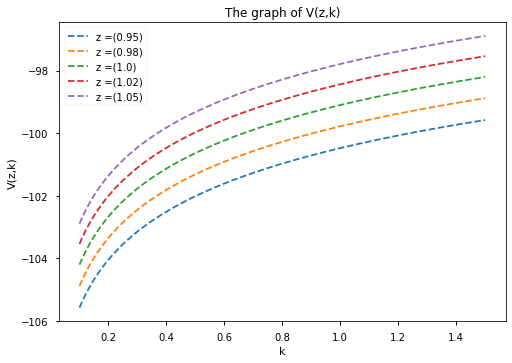

In [45]:
Model = LQ()
Model.Graphics()

# 2.2) Vaughan's Method

Now, we used the following  quadratic return equation above:

$$r(z,s,d) \simeq \begin{bmatrix}1 & W^T\end{bmatrix}\begin{bmatrix}Q_{11} & Q_{12}^T \\ Q_{12} & Q_{22}\end{bmatrix} \begin{bmatrix}1\\ W\end{bmatrix} \;\;\; \equiv \;\;\; \begin{bmatrix}1 & W^T\end{bmatrix}Q\begin{bmatrix}1 \\ W \end{bmatrix}$$ 

But this can be written in McGrattan (1990) way as follows:

$$ r(z,s,d) \equiv \;\; \begin{bmatrix} F^T \end{bmatrix} \begin{bmatrix} Q_{FF} \end{bmatrix} \begin{bmatrix} F \end{bmatrix} + d \begin{bmatrix} Q_{dd} \end{bmatrix}d + 2\begin{bmatrix} F^T \end{bmatrix} \begin{bmatrix} Q_{Fd}^T \end{bmatrix}d$$

(Remember that F = [1,z,s], W=[z,s,d])

And we also know that the law of motion is the following:

$$\begin{bmatrix} 1 \\ \hat{z}_{t+1} \\ \hat{k}_{t+1}\end{bmatrix}  = \begin{bmatrix} 1 & 0 & 0 \\ 0 & \rho & 0 \\ 0 & 0 & 0\end{bmatrix} \begin{bmatrix} 1 \\ \hat{z}_{t} \\ \hat{k}_{t} \end{bmatrix} + \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix} \hat{x_t} + \begin{bmatrix} 0 \\ 1 \\ 0 \end{bmatrix}\epsilon_{t+1}$$

Here:

- $\mathbb{Q} = Q_{FF} = Q[0:3, 0:3]$ 3x3 matrix
- $\mathbb{R} = Q_{dd} = Q[3,3] \;\;\;\;\;\;\;\;\;$      1x1 scalar   
- $\mathbb{W} = Q_{Fd}^T = Q[3, 0:3]^T \;\;$ 3x1 vector
- $\mathbb{A} = \begin{bmatrix} 1 & 0 & 0 \\ 0 & \rho & 0 \\ 0 & 0 & 0\end{bmatrix}$
- $\mathbb{B} = \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}$
- $\mathbb{C} = \begin{bmatrix} 0 \\ 1 \\ 0 \end{bmatrix}$






Now, since we know the A,B,C,R,Q,W; we can solve the Vaughan's method easily.

First, let's normalize everything to get rid of discount factor and cross product of state and control variables:

$$\tilde{X_t} = \beta^{\frac{t}{2}}X_t$$

$$\tilde{u_t} = \beta^{\frac{t}{2}}(u_t + R^{-1}W'X_t)$$

$$\tilde{A} = \sqrt{\beta} (A - BR^{-1}W')$$

$$\tilde{B} = \sqrt{\beta}B$$

$$\tilde{Q} = Q - WR^{-1}W'$$

Let's define now the following Hamiltonian Matrix:

$$\mathbb{H} = \begin{bmatrix} \tilde{A^{-1}}  & \tilde{A^{-1}} \tilde{B} R^{-1} \tilde{B'}\\ \tilde{Q}\tilde{A^{-1}} & \tilde{Q}\tilde{A^{-1}}\tilde{B} R^{-1} \tilde{B'} + \tilde{A'}\end{bmatrix}$$

and decompose it then order the eigenvalues such that first half of the eigenvalues exceed the unit root, and the second half is the reverse of the first half.


Then, Vaughan says that $P = V_{21}V_{11}^{-1}$ and $F = \dfrac{1}{(R + (\tilde{B}' P \tilde{B}))} (\tilde{B}'P \tilde{A}) +  R^{-1}W'$

In [5]:
class Vaughan:
    def __init__(self, α=0.7, β=0.98, ρ=0.9):
        self.α = α
        self.β = β
        self.ρ = ρ
        
        #Steady state values
        self.Z = 0
        self.S = np.log((α*β)**(1/(1-α)))
        self.D = np.log((α*β)**(1/(1-α)))
        
    def R(self, z, s, d):                                                     #Return Function
        return np.log(e**z * e**(self.α*s) - e**d)
    
    def derivatives(self):
        """Get Hessian and Jacobian to compute Q matrix of Marimon"""
        self.H = Derivatives_at_SS(self.R, self.Z, self.S, self.D).Hessian()  #Hessian at steady state
        self.J = Derivatives_at_SS(self.R, self.Z, self.S, self.D).Jacobian() #Jacobian at steady state
        self.Return = self.R(self.Z, self.S, self.D)                          #Return at steady state
        self.W_bar = np.matrix([self.Z, self.S, self.D]).T                    #Steady state values vector
    
    def Qanon(self):
        """Constructing Q Matrix of Marimon to find R,Q,W of Ellen"""
        Q11 = self.Return - np.matmul(self.W_bar.T, self.J) + 0.5 * np.matmul(np.matmul(self.W_bar.T, self.H),self.W_bar)

        Q12 = 0.5 * (self.J - np.matmul(self.H, self.W_bar))

        Q22 = 0.5 * self.H

        self.Q = np.array([[Q11.item(0), Q12.item((0,0)),Q12.item((1,0)),Q12.item((2,0))],
                       [Q12.item((0,0)),Q22.item((0,0)),Q22.item((0,1)),Q22.item((0,2))],
                       [Q12.item((1,0)),Q22.item((1,0)),Q22.item((1,1)),Q22.item((1,2))],
                       [Q12.item((2,0)),Q22.item((2,0)),Q22.item((2,1)),Q22.item((2,2))]])
        
        
    def ABC(self):
        """Defining A,B,C,R,Q,W"""
        self.A_ellen = np.array([[1, 0, 0],
                                 [0, self.ρ, 0],
                                 [0, 0, 0]])

        self.B_ellen = np.array([[0],[0],[1]])

        self.C_ellen = np.array([[0],[1],[0]])

        self.R_ellen = self.Q[3,3]

        self.Q_ellen = self.Q[0:3, 0:3]

        self.W_ellen = self.Q[3, 0:3]

        self.W_ellen.resize((3,1))

    def Normalize(self):
        """Normalizing"""
        self.A_tilde = np.sqrt(self.β) * (self.A_ellen - (self.R_ellen **(-1))*(self.B_ellen @ self.W_ellen.T))

        self.B_tilde = np.sqrt(self.β) * self.B_ellen

        self.Q_tilde = self.Q_ellen - (self.R_ellen**(-1) * self.W_ellen @ self.W_ellen.T)
    
    def Hamilton(self):
        """Defining the Hamiltonian"""
        A_tilde, B_tilde, Q_tilde = self.A_tilde, self.B_tilde, self.Q_tilde
        
        h11 = np.linalg.inv(self.A_tilde)
        h12 = self.R_ellen**(-1) * np.linalg.inv(self.A_tilde)@ self.B_tilde @ self.B_tilde.T
        h21 = self.Q_tilde @ np.linalg.inv(self.A_tilde)
        h22 = self.R_ellen**(-1) * self.Q_tilde @ np.linalg.inv(self.A_tilde) @ self.B_tilde @ self.B_tilde.T + self.A_tilde.T

        self.Hamiltonian = np.block([[h11,h12],[h21,h22]])
        
    def decomposition(self):
        """Decompose Hamiltonian matrix and order the eigenvalues and eigenvectors"""
        h = self.Hamiltonian.shape[0] // 2        #Midpoint
        
        val, vec = np.linalg.eig(self.Hamiltonian)
        
        idx_sorted = np.argsort(val)[::-1]        #Order in descending order
        idx_sorted[h:] = idx_sorted[h:][::-1]     #Reverse the order of the second half
        
        self.Λ, self.V = np.diag(val[idx_sorted]), vec[:,idx_sorted]
    
    def solving_P_and_F(self):
        """Get P and F"""
        self.derivatives()
        self.Qanon()
        self.ABC()
        self.Normalize()
        self.Hamilton()
        self.decomposition()
        
        h = self.Hamiltonian.shape[0] // 2
        self.V11, self.V21 = self.V[0:h,0:h], self.V[h:,0:h]
        
        self.P = self.V21 @ np.linalg.inv(self.V11)
        self.F = (1/(self.R_ellen + (self.B_tilde.T @ self.P @ self.B_tilde))) * (self.B_tilde.T @ self.P @ self.A_tilde)

In [6]:
Model_Vaughan = Vaughan()
Model_Vaughan.solving_P_and_F()
Model_Vaughan.P

array([[-9.91056911e+01,  1.34083610e+01,  1.10642859e+00],
       [ 1.34083610e+01,  2.86299988e-01, -1.43597085e-04],
       [ 1.10642859e+00, -1.43597085e-04, -5.13522829e-05]])

In [7]:
z_model = np.resize(np.log(np.ones(100)), (100,1))

s_model = np.resize((np.linspace(0.1, 1.5, 100)), (100,1))

s_model_logged = np.resize(np.log(np.linspace(0.1, 1.5, 100)), (100,1))

constant_model = np.resize(np.ones(100), (100,1))

state_vars = np.concatenate([constant_model, z_model, s_model_logged], axis=1)


In [8]:
values = []

for i in range(z_model.shape[0]):
    values.append(float(state_vars[i, :] @ Model_Vaughan.P @ state_vars[i, :].T))

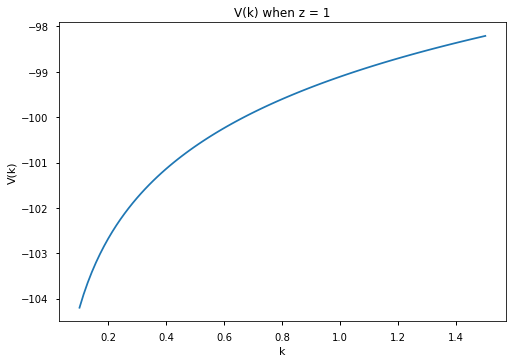

In [9]:
fig, ax = plt.subplots()

ax.plot(s_model, values)
ax.set_xlabel('k')
ax.set_ylabel('V(k)')
ax.set_title('V(k) when z = 1')

plt.show()

As you can see, the results of LQ with ricatti and vaughan are identical.